In [1]:
# Install tsflex and seglearn
!pip install tsflex --no-index --find-links=file:///kaggle/input/package
!pip install seglearn --no-index --find-links=file:///kaggle/input/package

Looking in links: file:///kaggle/input/package
Processing /kaggle/input/package/tsflex-0.3.0-py3-none-any.whl
Looking in links: file:///kaggle/input/package
Processing /kaggle/input/package/seglearn-1.2.5-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn import *
import glob

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Loading

In [4]:
p = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'

In [5]:
train = glob.glob(p+'train/**/**')
test = glob.glob(p+'test/**/**')
subjects = pd.read_csv(p+'subjects.csv')
tasks = pd.read_csv(p+'tasks.csv')
sub = pd.read_csv(p+'sample_submission.csv')

In [6]:
len(train), len(test)

(970, 2)

In [7]:
subjects.head(2)

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.0,63,M,3.0,30.0,NaN,0
1,05595e,1.0,56,M,8.0,28.0,NaN,0


In [8]:
tasks.head(2)

,Id,Begin,End,Task
0,02ab235146,10.00,190.48,Rest1
1,02ab235146,211.24,271.56,Rest2


In [9]:
tdcsfog_metadata=pd.read_csv(p+'tdcsfog_metadata.csv')
defog_metadata=pd.read_csv(p+'defog_metadata.csv')

In [10]:
tdcsfog_metadata['Module']='tdcsfog'
defog_metadata['Module']='defog'

In [11]:
metadata=pd.concat([tdcsfog_metadata,defog_metadata])
metadata.head(2)

,Id,Subject,Visit,Test,Medication,Module
0,003f117e14,13abfd,3,2.0,on,tdcsfog
1,009ee11563,d81e3a,4,2.0,on,tdcsfog


## Feature Engineering

In [12]:
tasks['Duration'] = tasks['End'] - tasks['Begin']
tasks = pd.pivot_table(tasks, values=['Duration'], index=['Id'], columns=['Task'], aggfunc='sum', fill_value=0)
tasks.columns = [c[-1] for c in tasks.columns]
tasks = tasks.reset_index()

## Clustering all tasks to nearest clusters
tasks['t_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(tasks[tasks.columns[1:]])

In [13]:
subjects = subjects.fillna(0).groupby('Subject').median()
subjects = subjects.reset_index()

## Clustering all subjects to nearest clusters
subjects['s_kmeans'] = cluster.KMeans(n_clusters=10, random_state=3).fit_predict(subjects[subjects.columns[1:]])
subjects=subjects.rename(columns={'Visit':'s_Visit','Age':'s_Age','YearsSinceDx':'s_YearsSinceDx','UPDRSIII_On':'s_UPDRSIII_On','UPDRSIII_Off':'s_UPDRSIII_Off','NFOGQ':'s_NFOGQ'})

In [14]:
## From Metadata and Subjects dataframe
complex_featlist=['Visit','Test','Medication','s_Visit','s_Age','s_YearsSinceDx','s_UPDRSIII_On','s_UPDRSIII_Off','s_NFOGQ','s_kmeans']

In [15]:
metadata_complex=metadata.merge(subjects,how='left',on='Subject').copy()

In [16]:
len(metadata_complex)

970

In [17]:
metadata_complex['Medication']=metadata_complex['Medication'].factorize()[0]  ## Changing from On/Off to 0/1.

In [18]:
metadata_complex.head(2)

,Id,Subject,Visit,Test,Medication,Module,s_Visit,s_Age,s_YearsSinceDx,s_UPDRSIII_On,s_UPDRSIII_Off,s_NFOGQ,s_kmeans
0,003f117e14,13abfd,3,2.0,0,tdcsfog,0.0,68.0,9.0,17.0,15.0,15.0,8
1,009ee11563,d81e3a,4,2.0,0,tdcsfog,0.0,71.0,10.0,42.0,0.0,24.0,1


## tsflex feature selection

In [19]:
# https://reader.elsevier.com/reader/sd/pii/S2352711021001904?token=37B0595F026ECFAFADE3BA1B280E37EC55CAF307DECCF7282D0EFB1258D766249CACAC5DE202D333E40F3B13FBD39844&originRegion=us-east-1&originCreation=20230414151308

In [20]:
from seglearn.feature_functions import base_features, emg_features

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper

In [21]:
basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV', 'AccML', 'AccAP'],    ## These 3 series will be used to extract features
    windows=[5_000],                            ## Rolling window of 5_000
    strides=[5_000],                            ## Similar value of windows, it can also be less than windows value
)

In [22]:
emg_feats = emg_features()              ## Coming from seglearn
del emg_feats['simple square integral']

In [23]:
emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV', 'AccML', 'AccAP'],
    windows=[5_000],
    strides=[5_000],
)

In [24]:
fc = FeatureCollection([basic_feats, emg_feats])    # Create the feature collection & calculate the features

In [25]:
fc

AccAP: (
	win: 5000  : [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['minimum'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['maximum'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {})    stride: ['5000'],
		FeatureDescriptor - func: FuncWrapper([s

## Feature Extraction

In [26]:
import pathlib

In [27]:
def reader(f):
    try:
        df = pd.read_csv(f, index_col="Time", usecols=['Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn' , 'Walking'])
        
        df['Id'] = f.split('/')[-1].split('.')[0]
        df['Module'] = pathlib.Path(f).parts[-2]
        
        df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
        
        df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)

        df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
        
        ## Apply the tsflex feature collections
        df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin").astype(np.float32)
        
        df = df.merge(df_feats, how="left", left_index=True, right_index=True)
        
        df.fillna(method="ffill", inplace=True)
        
        return df
    
    except: 
        pass

In [28]:
train = pd.concat([reader(f) for f in tqdm(train)]).fillna(0); print(train.shape)

  0%|          | 0/970 [00:00<?, ?it/s]

(20588374, 72)


In [29]:
train.head(2)

,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Id,Module,Time_frac,t_kmeans,Subject,Visit,Test,Medication,s_kmeans,AccAP__abs_energy__w=5000,AccAP__abs_sum__w=5000,AccAP__emg_var__w=5000,AccAP__kurt__w=5000,AccAP__maximum__w=5000,AccAP__mean__w=5000,AccAP__mean_abs__w=5000,AccAP__mean_crossings__w=5000,AccAP__median__w=5000,AccAP__minimum__w=5000,AccAP__mse__w=5000,AccAP__root_mean_square__w=5000,AccAP__skew__w=5000,AccAP__slope_sign_changes__w=5000,AccAP__std__w=5000,AccAP__var__w=5000,AccAP__waveform_length__w=5000,AccAP__willison_amplitude__w=5000,AccAP__zero_crossing__w=5000,AccML__abs_energy__w=5000,AccML__abs_sum__w=5000,AccML__emg_var__w=5000,AccML__kurt__w=5000,AccML__maximum__w=5000,AccML__mean__w=5000,AccML__mean_abs__w=5000,AccML__mean_crossings__w=5000,AccML__median__w=5000,AccML__minimum__w=5000,AccML__mse__w=5000,AccML__root_mean_square__w=5000,AccML__skew__w=5000,AccML__slope_sign_changes__w=5000,AccML__std__w=5000,AccML__var__w=5000,AccML__waveform_length__w=5000,AccML__willison_amplitude__w=5000,AccML__zero_crossing__w=5000,AccV__abs_energy__w=5000,AccV__abs_sum__w=5000,AccV__emg_var__w=5000,AccV__kurt__w=5000,AccV__maximum__w=5000,AccV__mean__w=5000,AccV__mean_abs__w=5000,AccV__mean_crossings__w=5000,AccV__median__w=5000,AccV__minimum__w=5000,AccV__mse__w=5000,AccV__root_mean_square__w=5000,AccV__skew__w=5000,AccV__slope_sign_changes__w=5000,AccV__std__w=5000,AccV__var__w=5000,AccV__waveform_length__w=5000,AccV__willison_amplitude__w=5000,AccV__zero_crossing__w=5000
0,-1.002697,0.022371,0.068304,0,0,0,be9d33541d,defog,0.000000,0.0,49f526,1,-1.0,0,2,115.534416,662.12384,0.023112,0.536912,0.36955,0.111433,0.132425,120.0,0.144087,-0.4458,115.534416,0.152009,-0.897214,1663.0,0.10339,0.01069,43.071453,4999.0,4999.0,39.403107,288.67923,0.007882,6.877556,0.684099,0.012571,0.057736,179.0,0.015336,-0.660446,39.403107,0.088773,0.103732,1269.0,0.087878,0.007723,54.090939,4999.0,4999.0,4976.811035,4958.188965,0.995561,25.696182,-0.617042,-0.991638,0.991638,0.0,-0.98608,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.10962,0.012017,75.765259,4999.0,4999.0
1,-1.002641,0.019173,0.066162,0,0,0,be9d33541d,defog,0.000008,0.0,49f526,1,-1.0,0,2,115.534416,662.12384,0.023112,0.536912,0.36955,0.111433,0.132425,120.0,0.144087,-0.4458,115.534416,0.152009,-0.897214,1663.0,0.10339,0.01069,43.071453,4999.0,4999.0,39.403107,288.67923,0.007882,6.877556,0.684099,0.012571,0.057736,179.0,0.015336,-0.660446,39.403107,0.088773,0.103732,1269.0,0.087878,0.007723,54.090939,4999.0,4999.0,4976.811035,4958.188965,0.995561,25.696182,-0.617042,-0.991638,0.991638,0.0,-0.98608,-2.295443,4976.811035,0.997678,-3.076039,1459.0,0.10962,0.012017,75.765259,4999.0,4999.0


In [30]:
cols = [c for c in train.columns if c not in ['Id','Subject','Module', 'Time', 'StartHesitation', 'Turn' , 'Walking', 'Valid', 'Task','Event']]

In [31]:
cols

['AccV',
 'AccML',
 'AccAP',
 'Time_frac',
 't_kmeans',
 'Visit',
 'Test',
 'Medication',
 's_kmeans',
 'AccAP__abs_energy__w=5000',
 'AccAP__abs_sum__w=5000',
 'AccAP__emg_var__w=5000',
 'AccAP__kurt__w=5000',
 'AccAP__maximum__w=5000',
 'AccAP__mean__w=5000',
 'AccAP__mean_abs__w=5000',
 'AccAP__mean_crossings__w=5000',
 'AccAP__median__w=5000',
 'AccAP__minimum__w=5000',
 'AccAP__mse__w=5000',
 'AccAP__root_mean_square__w=5000',
 'AccAP__skew__w=5000',
 'AccAP__slope_sign_changes__w=5000',
 'AccAP__std__w=5000',
 'AccAP__var__w=5000',
 'AccAP__waveform_length__w=5000',
 'AccAP__willison_amplitude__w=5000',
 'AccAP__zero_crossing__w=5000',
 'AccML__abs_energy__w=5000',
 'AccML__abs_sum__w=5000',
 'AccML__emg_var__w=5000',
 'AccML__kurt__w=5000',
 'AccML__maximum__w=5000',
 'AccML__mean__w=5000',
 'AccML__mean_abs__w=5000',
 'AccML__mean_crossings__w=5000',
 'AccML__median__w=5000',
 'AccML__minimum__w=5000',
 'AccML__mse__w=5000',
 'AccML__root_mean_square__w=5000',
 'AccML__skew__w=

In [32]:
pcols = ['StartHesitation', 'Turn' , 'Walking']

In [33]:
scols = ['Id', 'StartHesitation', 'Turn' , 'Walking']

In [34]:
train=train.reset_index(drop=True)

## Looking at the distribution of Time for different target variable

<AxesSubplot:>

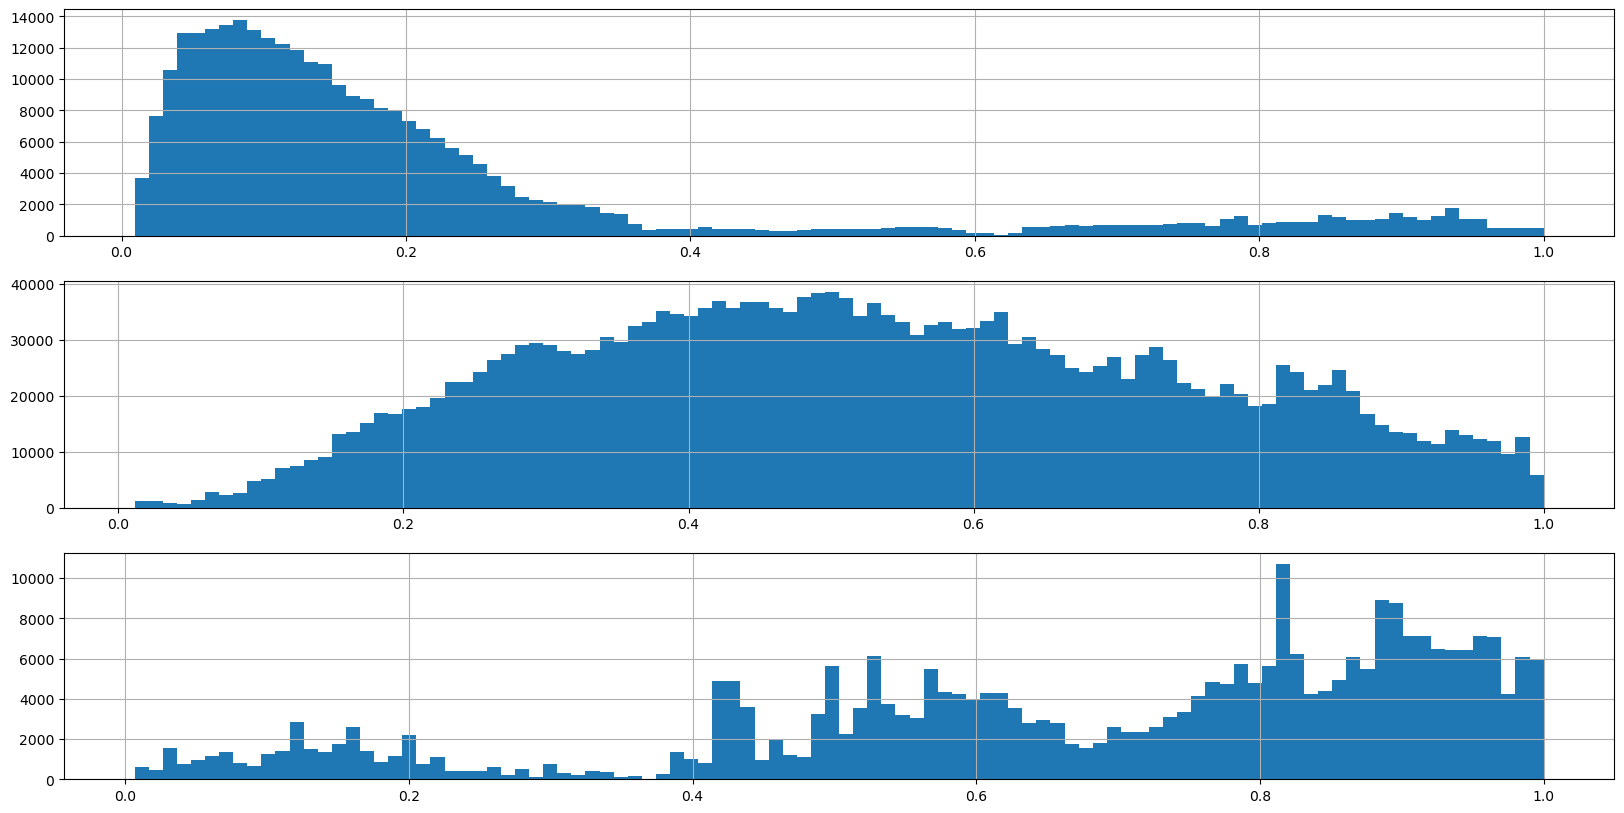

In [35]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(3,1,figsize=(20,10))

train.loc[train['StartHesitation']==1,'Time_frac'].hist(ax=ax[0],bins=100)
train.loc[train['Turn']==1,'Time_frac'].hist(ax=ax[1],bins=100)
train.loc[train['Walking']==1,'Time_frac'].hist(ax=ax[2],bins=100)

### Start Hesitation occurs at the beginning
### Turn occurs at the middle
### Walking occurs frequently at last stage.

### Time sequence: Start Hesitation > Turn > Walking

## Train the model

In [36]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import average_precision_score, make_scorer

In [38]:
best_params_ = {'estimator__colsample_bytree': 0.5282057895135501, 
 'estimator__learning_rate': 0.22659963168004743, 
 'estimator__max_depth': 8, 
 'estimator__min_child_weight': 3.1233911067827616, 
 'estimator__n_estimators': 291, 
 'estimator__subsample': 0.9961057796456088}

In [39]:
best_params_ = {kk: v for k, v in best_params_.items() for kk in k.split('__')}; del best_params_['estimator']

In [40]:
best_params_ 

{'colsample_bytree': 0.5282057895135501,
 'learning_rate': 0.22659963168004743,
 'max_depth': 8,
 'min_child_weight': 3.1233911067827616,
 'n_estimators': 291,
 'subsample': 0.9961057796456088}

In [41]:
from sklearn.base import clone

In [42]:
def custom_average_precision(y_true, y_pred):
    score = average_precision_score(y_true, y_pred)
    return 'average_precision', score, True

In [43]:
class LGBMMultiOutputRegressor(MultiOutputRegressor):
    def fit(self, X, y, eval_set=None, **fit_params):
        self.estimators_ = [clone(self.estimator) for _ in range(y.shape[1])]
        
        for i, estimator in enumerate(self.estimators_):
            if eval_set:
                fit_params['eval_set'] = [(eval_set[0], eval_set[1][:, i])]
            estimator.fit(X, y[:, i], **fit_params)
        
        return self

In [44]:
from sklearn.model_selection import GroupKFold

N_FOLDS=5
kfold = GroupKFold(N_FOLDS)
group_var = train.Subject
groups=kfold.split(train, groups=group_var)
regs=[]
cvs=[]
for fold, (tr_idx,te_idx ) in enumerate(tqdm(groups, total=N_FOLDS, desc="Folds")):
    tr_idx=pd.Series(tr_idx).sample(n=2000000,random_state=42).values #2000000
    
    # Create a base XGBoost regressor with the common parameters
    base_regressor = lgb.LGBMRegressor(**best_params_)

    # Wrap the base regressor with the MultiOutputRegressor
    multioutput_regressor = LGBMMultiOutputRegressor(base_regressor)

    x_tr,y_tr=train.loc[tr_idx,cols].to_numpy(),train.loc[tr_idx,pcols].to_numpy()
    x_te,y_te=train.loc[te_idx,cols].to_numpy(),train.loc[te_idx,pcols].to_numpy()

    multioutput_regressor.fit(
    x_tr,y_tr,
    eval_set=(x_te,y_te),
    eval_metric=custom_average_precision,
    early_stopping_rounds=25
    )
    regs.append(multioutput_regressor)
    cv=metrics.average_precision_score(y_te, multioutput_regressor.predict(x_te).clip(0.0,1.0))
    cvs.append(cv)
print(cvs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0578757	valid_0's average_precision: 0.130233
[2]	valid_0's l2: 0.0568393	valid_0's average_precision: 0.360881
[3]	valid_0's l2: 0.0568937	valid_0's average_precision: 0.32333
[4]	valid_0's l2: 0.0569729	valid_0's average_precision: 0.236865
[5]	valid_0's l2: 0.0565647	valid_0's average_precision: 0.292237
[6]	valid_0's l2: 0.0563773	valid_0's average_precision: 0.291197
[7]	valid_0's l2: 0.0564142	valid_0's average_precision: 0.288112
[8]	valid_0's l2: 0.0564494	valid_0's average_precision: 0.270473
[9]	valid_0's l2: 0.0564891	valid_0's average_precision: 0.248869
[10]	valid_0's l2: 0.0563303	valid_0's average_precision: 0.199375
[11]	valid_0's l2: 0.0563565	valid_0's average_precision: 0.188289
[12]	valid_0's l2: 0.0563726	valid_0's average_precision: 0.182079
[13]	valid_0's l2: 0.0563778	valid_0's average_precision: 0.181759
[14]	valid_0's l2: 0.0563302	valid_0's average_precision: 0.180522
[15]	valid_0's l2: 0.055521	valid_0's average_precision: 0.210562
[16]	v

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.192534	valid_0's average_precision: 0.401311
[2]	valid_0's l2: 0.183146	valid_0's average_precision: 0.456269
[3]	valid_0's l2: 0.174623	valid_0's average_precision: 0.495045
[4]	valid_0's l2: 0.168875	valid_0's average_precision: 0.54542
[5]	valid_0's l2: 0.168542	valid_0's average_precision: 0.543299
[6]	valid_0's l2: 0.163028	valid_0's average_precision: 0.566166
[7]	valid_0's l2: 0.155626	valid_0's average_precision: 0.603903
[8]	valid_0's l2: 0.147036	valid_0's average_precision: 0.638213
[9]	valid_0's l2: 0.146667	valid_0's average_precision: 0.635359
[10]	valid_0's l2: 0.146701	valid_0's average_precision: 0.633939
[11]	valid_0's l2: 0.144611	valid_0's average_precision: 0.638406
[12]	valid_0's l2: 0.140066	valid_0's average_precision: 0.64921
[13]	valid_0's l2: 0.139948	valid_0's average_precision: 0.644734
[14]	valid_0's l2: 0.139463	valid_0's average_precision: 0.648201
[15]	valid_0's l2: 0.135746	valid_0's average_precision: 0.665645
[16]	valid_0's l2: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0351791	valid_0's average_precision: 0.0906403
[2]	valid_0's l2: 0.0351826	valid_0's average_precision: 0.0976227
[3]	valid_0's l2: 0.0352559	valid_0's average_precision: 0.109936
[4]	valid_0's l2: 0.0379119	valid_0's average_precision: 0.0749621
[5]	valid_0's l2: 0.0379853	valid_0's average_precision: 0.0774947
[6]	valid_0's l2: 0.0400942	valid_0's average_precision: 0.0877357
[7]	valid_0's l2: 0.0404074	valid_0's average_precision: 0.0812523
[8]	valid_0's l2: 0.0404799	valid_0's average_precision: 0.0837001
[9]	valid_0's l2: 0.0408594	valid_0's average_precision: 0.0925915
[10]	valid_0's l2: 0.0412067	valid_0's average_precision: 0.103526
[11]	valid_0's l2: 0.0412764	valid_0's average_precision: 0.110131
[12]	valid_0's l2: 0.0412771	valid_0's average_precision: 0.111863
[13]	valid_0's l2: 0.0436306	valid_0's average_precision: 0.110421
[14]	valid_0's l2: 0.0439625	valid_0's average_precision: 0.107943
[15]	valid_0's l2: 0.0439557	valid_0's average_precision: 0.101

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00866411	valid_0's average_precision: 0.00855808
[2]	valid_0's l2: 0.00869272	valid_0's average_precision: 0.00853803
[3]	valid_0's l2: 0.00879094	valid_0's average_precision: 0.0346622
[4]	valid_0's l2: 0.00879457	valid_0's average_precision: 0.030599
[5]	valid_0's l2: 0.00880522	valid_0's average_precision: 0.0338696
[6]	valid_0's l2: 0.00881842	valid_0's average_precision: 0.0359835
[7]	valid_0's l2: 0.00894771	valid_0's average_precision: 0.0429243
[8]	valid_0's l2: 0.00895584	valid_0's average_precision: 0.0465572
[9]	valid_0's l2: 0.00894942	valid_0's average_precision: 0.0533238
[10]	valid_0's l2: 0.00894126	valid_0's average_precision: 0.112889
[11]	valid_0's l2: 0.00908123	valid_0's average_precision: 0.118936
[12]	valid_0's l2: 0.00929456	valid_0's average_precision: 0.170039
[13]	valid_0's l2: 0.00934358	valid_0's average_precision: 0.125207
[14]	valid_0's l2: 0.00968968	valid_0's average_precision: 0.132596
[15]	valid_0's l2: 0.00966741	valid_0's average

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0942189	valid_0's average_precision: 0.456928
[2]	valid_0's l2: 0.0862825	valid_0's average_precision: 0.492516
[3]	valid_0's l2: 0.0858093	valid_0's average_precision: 0.48188
[4]	valid_0's l2: 0.0815539	valid_0's average_precision: 0.533743
[5]	valid_0's l2: 0.0806555	valid_0's average_precision: 0.504913
[6]	valid_0's l2: 0.0797961	valid_0's average_precision: 0.501491
[7]	valid_0's l2: 0.0802288	valid_0's average_precision: 0.486463
[8]	valid_0's l2: 0.0806536	valid_0's average_precision: 0.474181
[9]	valid_0's l2: 0.078324	valid_0's average_precision: 0.497989
[10]	valid_0's l2: 0.077707	valid_0's average_precision: 0.511544
[11]	valid_0's l2: 0.0787186	valid_0's average_precision: 0.500258
[12]	valid_0's l2: 0.0783684	valid_0's average_precision: 0.500247
[13]	valid_0's l2: 0.0786305	valid_0's average_precision: 0.496403
[14]	valid_0's l2: 0.0780361	valid_0's average_precision: 0.505779
[15]	valid_0's l2: 0.0779819	valid_0's average_precision: 0.505158
[16]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00448858	valid_0's average_precision: 0.00435039
[2]	valid_0's l2: 0.00577281	valid_0's average_precision: 0.00726061
[3]	valid_0's l2: 0.00596131	valid_0's average_precision: 0.00623139
[4]	valid_0's l2: 0.00591489	valid_0's average_precision: 0.00962507
[5]	valid_0's l2: 0.00591972	valid_0's average_precision: 0.0113761
[6]	valid_0's l2: 0.00593688	valid_0's average_precision: 0.0115008
[7]	valid_0's l2: 0.00611328	valid_0's average_precision: 0.011064
[8]	valid_0's l2: 0.00613528	valid_0's average_precision: 0.0101006
[9]	valid_0's l2: 0.00640056	valid_0's average_precision: 0.0104158
[10]	valid_0's l2: 0.00649136	valid_0's average_precision: 0.0109254
[11]	valid_0's l2: 0.00658145	valid_0's average_precision: 0.0110613
[12]	valid_0's l2: 0.00658344	valid_0's average_precision: 0.0110088
[13]	valid_0's l2: 0.00663173	valid_0's average_precision: 0.0105728
[14]	valid_0's l2: 0.00663822	valid_0's average_precision: 0.0102079
[15]	valid_0's l2: 0.00667801	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00135949	valid_0's average_precision: 0.000849382
[2]	valid_0's l2: 0.00156377	valid_0's average_precision: 0.00535368
[3]	valid_0's l2: 0.00175237	valid_0's average_precision: 0.0116093
[4]	valid_0's l2: 0.00205457	valid_0's average_precision: 0.00591549
[5]	valid_0's l2: 0.00198554	valid_0's average_precision: 0.0114264
[6]	valid_0's l2: 0.00197932	valid_0's average_precision: 0.0142905
[7]	valid_0's l2: 0.00197722	valid_0's average_precision: 0.0163639
[8]	valid_0's l2: 0.00201654	valid_0's average_precision: 0.0130548
[9]	valid_0's l2: 0.00205669	valid_0's average_precision: 0.0142885
[10]	valid_0's l2: 0.0020557	valid_0's average_precision: 0.0156168
[11]	valid_0's l2: 0.00208396	valid_0's average_precision: 0.0159668
[12]	valid_0's l2: 0.00208887	valid_0's average_precision: 0.0160864
[13]	valid_0's l2: 0.002142	valid_0's average_precision: 0.0162049
[14]	valid_0's l2: 0.0021945	valid_0's average_precision: 0.0160329
[15]	valid_0's l2: 0.00226305	valid_0's ave

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0609265	valid_0's average_precision: 0.1187
[2]	valid_0's l2: 0.0595301	valid_0's average_precision: 0.133581
[3]	valid_0's l2: 0.0587571	valid_0's average_precision: 0.135375
[4]	valid_0's l2: 0.0583989	valid_0's average_precision: 0.153501
[5]	valid_0's l2: 0.0580788	valid_0's average_precision: 0.166167
[6]	valid_0's l2: 0.0577802	valid_0's average_precision: 0.175096
[7]	valid_0's l2: 0.0575876	valid_0's average_precision: 0.179099
[8]	valid_0's l2: 0.0578461	valid_0's average_precision: 0.172491
[9]	valid_0's l2: 0.0577619	valid_0's average_precision: 0.174798
[10]	valid_0's l2: 0.0581627	valid_0's average_precision: 0.173967
[11]	valid_0's l2: 0.0582645	valid_0's average_precision: 0.174094
[12]	valid_0's l2: 0.0581618	valid_0's average_precision: 0.177231
[13]	valid_0's l2: 0.0572771	valid_0's average_precision: 0.19211
[14]	valid_0's l2: 0.0573319	valid_0's average_precision: 0.190971
[15]	valid_0's l2: 0.0570541	valid_0's average_precision: 0.200993
[16]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00188031	valid_0's average_precision: 0.00168002
[2]	valid_0's l2: 0.00196116	valid_0's average_precision: 0.00236058
[3]	valid_0's l2: 0.00198891	valid_0's average_precision: 0.00189589
[4]	valid_0's l2: 0.00198115	valid_0's average_precision: 0.00190925
[5]	valid_0's l2: 0.0019629	valid_0's average_precision: 0.00492321
[6]	valid_0's l2: 0.00195206	valid_0's average_precision: 0.00521831
[7]	valid_0's l2: 0.00194254	valid_0's average_precision: 0.00505944
[8]	valid_0's l2: 0.00206589	valid_0's average_precision: 0.00661696
[9]	valid_0's l2: 0.00212229	valid_0's average_precision: 0.00620147
[10]	valid_0's l2: 0.00221836	valid_0's average_precision: 0.00577812
[11]	valid_0's l2: 0.00222634	valid_0's average_precision: 0.00614046
[12]	valid_0's l2: 0.00226511	valid_0's average_precision: 0.00558327
[13]	valid_0's l2: 0.00227326	valid_0's average_precision: 0.00544321
[14]	valid_0's l2: 0.00231488	valid_0's average_precision: 0.00524055
[15]	valid_0's l2: 0.00234861	

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00600501	valid_0's average_precision: 0.00707307
[2]	valid_0's l2: 0.00602162	valid_0's average_precision: 0.0159298
[3]	valid_0's l2: 0.00603628	valid_0's average_precision: 0.0138193
[4]	valid_0's l2: 0.00606185	valid_0's average_precision: 0.0134103
[5]	valid_0's l2: 0.00601323	valid_0's average_precision: 0.0174722
[6]	valid_0's l2: 0.00605232	valid_0's average_precision: 0.0286756
[7]	valid_0's l2: 0.0060481	valid_0's average_precision: 0.0290232
[8]	valid_0's l2: 0.00606059	valid_0's average_precision: 0.0306689
[9]	valid_0's l2: 0.00606697	valid_0's average_precision: 0.030264
[10]	valid_0's l2: 0.00613336	valid_0's average_precision: 0.0295643
[11]	valid_0's l2: 0.0061572	valid_0's average_precision: 0.0277124
[12]	valid_0's l2: 0.00616584	valid_0's average_precision: 0.0295768
[13]	valid_0's l2: 0.00616066	valid_0's average_precision: 0.0282368
[14]	valid_0's l2: 0.00618314	valid_0's average_precision: 0.0278793
[15]	valid_0's l2: 0.00617077	valid_0's avera

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0736703	valid_0's average_precision: 0.335534
[2]	valid_0's l2: 0.0692755	valid_0's average_precision: 0.387364
[3]	valid_0's l2: 0.0676452	valid_0's average_precision: 0.40276
[4]	valid_0's l2: 0.0655798	valid_0's average_precision: 0.412151
[5]	valid_0's l2: 0.0645959	valid_0's average_precision: 0.415998
[6]	valid_0's l2: 0.0644825	valid_0's average_precision: 0.419426
[7]	valid_0's l2: 0.0631098	valid_0's average_precision: 0.441625
[8]	valid_0's l2: 0.0625066	valid_0's average_precision: 0.448346
[9]	valid_0's l2: 0.0623842	valid_0's average_precision: 0.446646
[10]	valid_0's l2: 0.0621293	valid_0's average_precision: 0.451627
[11]	valid_0's l2: 0.0623244	valid_0's average_precision: 0.44718
[12]	valid_0's l2: 0.0618803	valid_0's average_precision: 0.456422
[13]	valid_0's l2: 0.0619808	valid_0's average_precision: 0.456297
[14]	valid_0's l2: 0.0620536	valid_0's average_precision: 0.45716
[15]	valid_0's l2: 0.0618511	valid_0's average_precision: 0.462413
[16]	va

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0258308	valid_0's average_precision: 0.0269351
[2]	valid_0's l2: 0.0258695	valid_0's average_precision: 0.031453
[3]	valid_0's l2: 0.0259272	valid_0's average_precision: 0.0309298
[4]	valid_0's l2: 0.0259784	valid_0's average_precision: 0.0315085
[5]	valid_0's l2: 0.0260082	valid_0's average_precision: 0.0313855
[6]	valid_0's l2: 0.0260254	valid_0's average_precision: 0.0305788
[7]	valid_0's l2: 0.026055	valid_0's average_precision: 0.0327678
[8]	valid_0's l2: 0.0260731	valid_0's average_precision: 0.0318353
[9]	valid_0's l2: 0.0261013	valid_0's average_precision: 0.0322116
[10]	valid_0's l2: 0.0261147	valid_0's average_precision: 0.0326074
[11]	valid_0's l2: 0.0261275	valid_0's average_precision: 0.0387995
[12]	valid_0's l2: 0.0261384	valid_0's average_precision: 0.039251
[13]	valid_0's l2: 0.0261383	valid_0's average_precision: 0.0413082
[14]	valid_0's l2: 0.0261419	valid_0's average_precision: 0.0414002
[15]	valid_0's l2: 0.0261577	valid_0's average_precision: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.000653185	valid_0's average_precision: 0.00044468
[2]	valid_0's l2: 0.000609592	valid_0's average_precision: 0.0034996
[3]	valid_0's l2: 0.000725825	valid_0's average_precision: 0.00201993
[4]	valid_0's l2: 0.000822284	valid_0's average_precision: 0.00193567
[5]	valid_0's l2: 0.000854178	valid_0's average_precision: 0.00351268
[6]	valid_0's l2: 0.000872308	valid_0's average_precision: 0.00349387
[7]	valid_0's l2: 0.000948873	valid_0's average_precision: 0.00374412
[8]	valid_0's l2: 0.00100741	valid_0's average_precision: 0.00403111
[9]	valid_0's l2: 0.00101176	valid_0's average_precision: 0.00369498
[10]	valid_0's l2: 0.00101095	valid_0's average_precision: 0.00361589
[11]	valid_0's l2: 0.00107835	valid_0's average_precision: 0.00357703
[12]	valid_0's l2: 0.00107904	valid_0's average_precision: 0.00356118
[13]	valid_0's l2: 0.00108224	valid_0's average_precision: 0.00366746
[14]	valid_0's l2: 0.00108805	valid_0's average_precision: 0.00344487
[15]	valid_0's l2: 0.00

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.0482308	valid_0's average_precision: 0.122564
[2]	valid_0's l2: 0.0465905	valid_0's average_precision: 0.130785
[3]	valid_0's l2: 0.0462238	valid_0's average_precision: 0.123464
[4]	valid_0's l2: 0.045816	valid_0's average_precision: 0.128908
[5]	valid_0's l2: 0.0454631	valid_0's average_precision: 0.137689
[6]	valid_0's l2: 0.0453136	valid_0's average_precision: 0.143603
[7]	valid_0's l2: 0.0440213	valid_0's average_precision: 0.165769
[8]	valid_0's l2: 0.04377	valid_0's average_precision: 0.172747
[9]	valid_0's l2: 0.0435837	valid_0's average_precision: 0.179535
[10]	valid_0's l2: 0.0436359	valid_0's average_precision: 0.181958
[11]	valid_0's l2: 0.0437507	valid_0's average_precision: 0.182792
[12]	valid_0's l2: 0.0438049	valid_0's average_precision: 0.186891
[13]	valid_0's l2: 0.043834	valid_0's average_precision: 0.188775
[14]	valid_0's l2: 0.043799	valid_0's average_precision: 0.190745
[15]	valid_0's l2: 0.0437701	valid_0's average_precision: 0.196805
[16]	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.00437416	valid_0's average_precision: 0.00385485
[2]	valid_0's l2: 0.00432861	valid_0's average_precision: 0.00424554
[3]	valid_0's l2: 0.00436863	valid_0's average_precision: 0.0060113
[4]	valid_0's l2: 0.00439231	valid_0's average_precision: 0.00590593
[5]	valid_0's l2: 0.00438036	valid_0's average_precision: 0.005802
[6]	valid_0's l2: 0.00439906	valid_0's average_precision: 0.00561918
[7]	valid_0's l2: 0.0044095	valid_0's average_precision: 0.00563707
[8]	valid_0's l2: 0.00445638	valid_0's average_precision: 0.00596444
[9]	valid_0's l2: 0.00447454	valid_0's average_precision: 0.00594162
[10]	valid_0's l2: 0.00447175	valid_0's average_precision: 0.00797505
[11]	valid_0's l2: 0.00447025	valid_0's average_precision: 0.00798366
[12]	valid_0's l2: 0.00451825	valid_0's average_precision: 0.00836501
[13]	valid_0's l2: 0.00456169	valid_0's average_precision: 0.00812454
[14]	valid_0's l2: 0.0045948	valid_0's average_precision: 0.00770749
[15]	valid_0's l2: 0.00460106	vali

## Predict for Test

In [45]:
sub['t'] = 0
submission = []
for f in test:
    df = pd.read_csv(f)
    df.set_index('Time', drop=True, inplace=True)

    df['Id'] = f.split('/')[-1].split('.')[0]
#     df = df.fillna(0).reset_index(drop=True)
    df['Time_frac']=(df.index/df.index.max()).values#currently the index of data is actually "Time"
    df = pd.merge(df, tasks[['Id','t_kmeans']], how='left', on='Id').fillna(-1)
#     df = pd.merge(df, subjects[['Id','s_kmeans']], how='left', on='Id').fillna(-1)
    df = pd.merge(df, metadata_complex[['Id','Subject']+['Visit','Test','Medication','s_kmeans']], how='left', on='Id').fillna(-1)
    df_feats = fc.calculate(df, return_df=True, include_final_window=True, approve_sparsity=True, window_idx="begin")
    df = df.merge(df_feats, how="left", left_index=True, right_index=True)
    df.fillna(method="ffill", inplace=True)
#     res = pd.DataFrame(np.round(reg.predict(df[cols]).clip(0.0,1.0),3), columns=pcols)
    
    res_vals=[]
    for i_fold in range(N_FOLDS):
        res_val=np.round(regs[i_fold].predict(df[cols]).clip(0.0,1.0),3)
        res_vals.append(np.expand_dims(res_val,axis=2))
    res_vals=np.mean(np.concatenate(res_vals,axis=2),axis=2)
    res = pd.DataFrame(res_vals, columns=pcols)
    
    df = pd.concat([df,res], axis=1)
    df['Id'] = df['Id'].astype(str) + '_' + df.index.astype(str)
    submission.append(df[scols])
submission = pd.concat(submission)
submission = pd.merge(sub[['Id']], submission, how='left', on='Id').fillna(0.0)
submission[scols].to_csv('submission.csv', index=False)
